In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys
import os
import math
from tueplots.constants.color import rgb
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

Agricultural water withdrawal

Agricultural water as a share of total water withdrawals, 2019

Agricultural water withdrawal as % of total renewable water resources

Agricultural water withdrawal as % of total water withdrawal

Cultivated area (arable land + permanent crops)


In [115]:
# discrete colormap

def create_discrete_colormap():
    # Define the colors for the colormap
    colors = [(1, 1, 0, 0.3), (0.8, 1, 0.1, 0.5), (0.6, 0.8, 0.2, 0.7), (0.3, 0.6, 0.4, 0.7), (0.2, 0.4, 0.6, 1), (0, 0.2, 0.8, 1), (0, 0.0, 0.8, 1), (0, 0, 0.5, 1)]  # Yellow, Light Blue, Dark Blue
    boundaries = [0, 0.005, 0.01, 0.1, 1, 5, 10, 50, 100]  # Custom boundaries for each color segment

    # Create a colormap using LinearSegmentedColormap
    cmap_name = 'custom_colormap'
    cmap = ListedColormap(colors)

    # Create a norm instance to map data values to the colormap
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    return cmap, norm

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


Text(0.5, 0.05, 'Source: AQUASTAT')

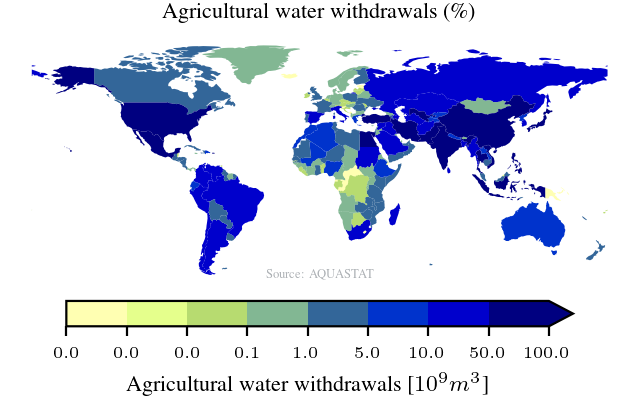

In [119]:
from src.aquastat_utils import get_aquastat
from src.aquastat_utils import plot_world
import geopandas as gpd
from src.utils import to_dat_path
from src.aquastat_utils import rename_aquastat_country

df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Agricultural Water Withdrawal'''
year = 2020
variables = ["Agricultural water withdrawal"]
title = 'Agricultural water withdrawals (\%)'
'''plot'''
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap=custom_cmap, norm = norm,
            legend_kwds={'label': "Agricultural water withdrawals [$10^9 m^3$]", 'orientation': "horizontal",
                        'shrink': 0.8, 'extend': 'max'})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)
